# Create a Feature Store, use SageMaker Data wrangler for feature engineering and SageMaker Processing Job for Data Ingestion

<div class="alert alert-info"> 💡 <strong> Quick Start </strong>
To save your processed data to feature store, <strong><a style="color: #0397a7 " href="#Create-Feature-Group">
    <u>Click here to create a feature group</u></a> and follow the instruction to run a SageMaker processing job.
</strong>
</div>

This notebook uses Amazon SageMaker Feature Store (Feature Store) to create a feature group, 
executes your Data Wrangler Flow `orders.flow` on the entire dataset using a SageMaker 
Processing Job and ingest processed data to Feature Store. 

---

## Contents

1. [Notebook Preparation](#Notebook-Preparation)
   1. [Imports](#Imports)
   1. [Check and update Sagemaker version](#Check-and-update-Sagemaker-version)
   1. [Logging Settings](#Logging-Settings)
   1. [Custom Functions](#Custom-Functions)
   1. [Module Configurations](#Module-Configurations)
1. [Data Preparation](#Data-Preparation)
1. [Create Feature Group](#Create-Feature-Group)
   1. [Define Feature Group](#Define-Feature-Group)
   1. [Configure Feature Group](#Configure-Feature-Group)
   1. [Initialize & Create Feature Group](#Initialize-&-Create-Feature-Group)
1. [Creating a workflow using Data Wrangler (OPTIONAL)](#Creating-a-workflow-using-Data-Wrangler-(OPTIONAL))
1. [Processing Job: Inputs and Outputs](#Inputs-and-Outputs)
1. [Run Processing Job](#Run-Processing-Job)
   1. [Job Configurations](#Job-Configurations)
   1. [Create and Execute Processing Job](#Create-and-Execute-Processing-Job)
   1. [Job Status](#Job-Status)
1. [Verify Processing Job Results](#Verify-Processing-Job-Results)
1. [Storing Variable Values](#Storing-Variable-Values)

## Notebook Preparation

#### Imports

In [ ]:
import sagemaker 
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker import get_execution_role
from time import gmtime, strftime, sleep
import pandas as pd
import numpy as np
import subprocess
import sagemaker
import logging
import importlib
import time
import sys
import uuid

#### Check and update Sagemaker version

In [ ]:
if sagemaker.__version__ < '2.48.1':
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'sagemaker==2.48.1'])
    importlib.reload(sagemaker)

#### Logging Settings

In [ ]:
logger = logging.getLogger('__name__')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())
logger.info(f'Using SageMaker version: {sagemaker.__version__}')
logger.info(f'Using Pandas version: {pd.__version__}')

#### Custom Functions

In [ ]:
def get_container(region):
    registries = {
          "af-south-1": "143210264188",
          "ap-east-1": "707077482487",
          "ap-northeast-1": "649008135260",
          "ap-northeast-2": "131546521161",
          "ap-south-1": "089933028263",
          "ap-southeast-1": "119527597002",
          "ap-southeast-2": "422173101802",
          "ca-central-1": "557239378090",
          "eu-central-1": "024640144536",
          "eu-north-1": "054986407534",
          "eu-south-1": "488287956546",
          "eu-west-1": "245179582081",
          "eu-west-2": "894491911112",
          "eu-west-3": "807237891255",
          "me-south-1": "376037874950",
          "sa-east-1": "424196993095",
          "us-east-1": "663277389841",
          "us-east-2": "415577184552",
          "us-west-1": "926135532090",
          "us-west-2": "174368400705",
          "cn-north-1": "245909111842",
          "cn-northwest-1": "249157047649"
        }
    return registries[region]

#### Module Configurations 
##### (Sagemaker session, S3 Bucket and Folder settings, etc.)

In [ ]:
# You can configure this with your own bucket name, workshop prefix & folder path, etc.
bucket = None
fs_champions_workshop_prefix = None
workshopfolder = None

In [ ]:
# Sagemaker session
sess = sagemaker.Session()

if bucket is None:
    bucket = sess.default_bucket()
if fs_champions_workshop_prefix is None:
    fs_champions_workshop_prefix = "fscw"
if workshopfolder is None:
    workshopfolder=f'sagemaker-feature-store/{fs_champions_workshop_prefix}/'
bucketlocation=f's3://{bucket}/{workshopfolder}data/'

logger.info(f'SageMaker FSCW S3 bucket = {bucket}')
logger.info(f'workshopfolder = {workshopfolder}')
# IAM role for executing the processing job.
iam_role = sagemaker.get_execution_role()

## Data Preparation
#### Upload the orders.csv raw file to the S3 bucket folder

In [ ]:
import os
import json
import boto3

orders_csv_file = 'orders.csv'
orders_df = pd.read_csv(orders_csv_file)
orders_df.head(10)

In [ ]:
# Upload orders.csv to S3
s3_client = boto3.client("s3")
orders_upload_file=f'{workshopfolder}data/{orders_csv_file}'
logger.info(f'orders_upload_file = {orders_upload_file}')
s3_client.upload_file(orders_csv_file, bucket, orders_upload_file)

In [ ]:
print(f"Data source: {f'{bucketlocation}'}")

## Create Feature Group

_What is a feature group_

A single feature corresponds to a column in your dataset. A feature group is a predefined schema for a 
collection of features - each feature in the feature group has a specified data type and name. 
A single record in a feature group corresponds to a row in your dataframe. A feature store is a 
collection of feature groups. To learn more about SageMaker Feature Store, see 
[Amazon Feature Store Documentation](http://docs.aws.amazon.com/sagemaker/latest/dg/feature-store.html).

### Define Feature Group
Select Record identifier and Event time feature name. These are required parameters for feature group
creation.
* **Record identifier name** is the name of the feature defined in the feature group's feature definitions 
whose value uniquely identifies a Record defined in the feature group's feature definitions.
* **Event time feature name** is the name of the EventTime feature of a Record in FeatureGroup. An EventTime 
is a timestamp that represents the point in time when a new event occurs that corresponds to the creation or 
update of a Record in the FeatureGroup. All Records in the FeatureGroup must have a corresponding EventTime.

<div class="alert alert-info"> 💡Record identifier and Event time feature name are required 
for feature group. After filling in the values, you can choose <b>Run Selected Cell and All Below</b> 
from the Run Menu from the menu bar. 
</div>

In [ ]:
record_identifier_feature_name = 'order_id'
if record_identifier_feature_name is None:
   raise SystemExit("Select a column name as the feature group record identifier.")

event_time_feature_name = 'event_time'
if event_time_feature_name is None:
   raise SystemExit("Select a column name as the event time feature name.")

### Feature Definitions
The following is a list of the feature names and feature types of the final dataset that will be produced 
when your data flow is used to process your input dataset. These are automatically generated from the 
from `Source: Orders.csv` schema. To save from a different step, go to Data Wrangler to 
select a new step to export.

<div class="alert alert-info"> 💡 <strong> Configurable Settings </strong>

1. You can select a subset of the features. By default all columns of the result dataframe will be used as 
features.
2. You can change the Data Wrangler data type to one of the Feature Store supported types 
(<b>Integral</b>, <b>Fractional</b>, or <b>String</b>). The default type is set to <b>String</b>. 
This means that, if a column in your dataset is not a <b>float</b> or <b>long</b> type, it will default 
to <b>String</b> in your Feature Store.

For <b>Event Time</b> features, make sure the format follows the feature store
<strong>
    <a style="color: #0397a7 " href="https://docs.aws.amazon.com/sagemaker/latest/dg/feature-store-quotas.html#feature-store-data-types">
    <u>Event Time feature format</u>
    </a>
</strong>
</div>

The following is a list of the feature names and data types of the final dataset that will be produced when your data flow is used to process your input dataset of orders.

In [ ]:
column_schemas = [
    {
        "name": "order_id",
        "type": "string"
    },
    {
        "name": "customer_id",
        "type": "string"
    },
    {
        "name": "product_id",
        "type": "string"
    },
    {
        "name": "purchase_amount",
        "type": "float"
    },
    {
        "name": "is_reordered",
        "type": "long"
    },
    {
        "name": "purchased_on",
        "type": "string"
    },
    {
        "name": "event_time",
        "type": "string"
    }
]

Below we create the SDK input for those feature definitions. Some schema types in Data Wrangler are not 
supported by Feature Store. The following will create a default_FG_type set to String for these types.

In [ ]:
from sagemaker.feature_store.feature_definition import FeatureDefinition
from sagemaker.feature_store.feature_definition import FeatureTypeEnum

default_feature_type = FeatureTypeEnum.STRING
column_to_feature_type_mapping = {
    "float": FeatureTypeEnum.FRACTIONAL,
    "long": FeatureTypeEnum.INTEGRAL
}

feature_definitions = [
    FeatureDefinition(
        feature_name=column_schema['name'], 
        feature_type=column_to_feature_type_mapping.get(column_schema['type'], default_feature_type)
    ) for column_schema in column_schemas
]
logger.info(f'feature definitions: {feature_definitions}')

## Configure Feature Group

<div class="alert alert-info"> 💡 <strong> Configurable Settings </strong>

1. <b>feature_group_name</b>: name of the feature group.
1. <b>feature_store_offline_s3_uri</b>: SageMaker FeatureStore writes the data in the OfflineStore of a FeatureGroup to a S3 location owned by you.
1. <b>enable_online_store</b>: controls if online store is enabled. Enabling the online store allows quick access to the latest value for a Record via the GetRecord API.
1. <b>iam_role</b>: IAM role for executing the processing job.
</div>

In [ ]:
# Calculate current_timestamp to create unique entries
current_timestamp = strftime('%m-%d-%H-%M-%S', gmtime())

In [ ]:
# flow name and an unique ID for this export (used later as the processing job name for the export)
flow_name = "orders"
flow_export_name = f'DWF-Orders'

# feature group name, with flow_name and an unique id. You can give it a customized name
feature_group_name = f"{fs_champions_workshop_prefix}-{flow_name}-{current_timestamp}"
logger.info(f'Feature Group Name: {feature_group_name}')

# SageMaker FeatureStore writes the data in the OfflineStore of a FeatureGroup to a 
# S3 location owned by you.
feature_store_offline_s3_uri = 's3://' + bucket

# controls if online store is enabled. Enabling the online store allows quick access to 
# the latest value for a Record via the GetRecord API.
enable_online_store = True

### Initialize & Create Feature Group

In [ ]:
# Initialize Boto3 session that is required to create feature group
import boto3
from sagemaker.session import Session

region = boto3.Session().region_name
boto_session = boto3.Session(region_name=region)

sagemaker_client = boto_session.client(service_name='sagemaker', region_name=region)
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name=region)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

Feature group is initialized and created below

In [ ]:
from sagemaker.feature_store.feature_group import FeatureGroup

feature_group = FeatureGroup(
    name=feature_group_name, sagemaker_session=feature_store_session, feature_definitions=feature_definitions)

feature_group.create(
    s3_uri=feature_store_offline_s3_uri,
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=iam_role,
    enable_online_store=enable_online_store
)

Invoke the Feature Store API to create the feature group and wait until it is ready

In [ ]:
import time
def wait_for_feature_group_creation_complete(feature_group):
    """Helper function to wait for the completions of creating a feature group"""
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise SystemExit(f"Failed to create feature group {feature_group.name}: {status}")
    print(f"FeatureGroup {feature_group.name} successfully created.")

wait_for_feature_group_creation_complete(feature_group=feature_group)

Now that the feature group is created, You will use a processing job to process your 
        data at scale and ingest the transformed data into this feature group.

### Verify created feature groups

In [ ]:
# Use Describe command to get the details of the created feature groups
feature_group.describe()

## Creating a workflow using Data Wrangler (OPTIONAL)
[SKIP this section](#Inputs-and-Outputs)

### ** BEGIN **

##### Follow the below steps to create the dwf-orders.flow using Data Wrangler (DW)

   #### 1. Please follow these steps for Opening DW    
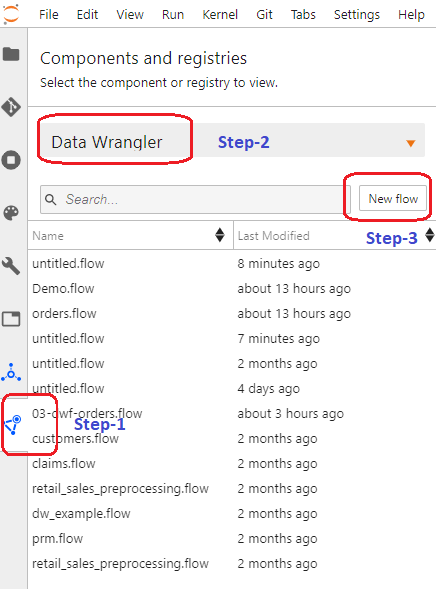

   #### 2. Please follow these steps to open S3 as your source.    
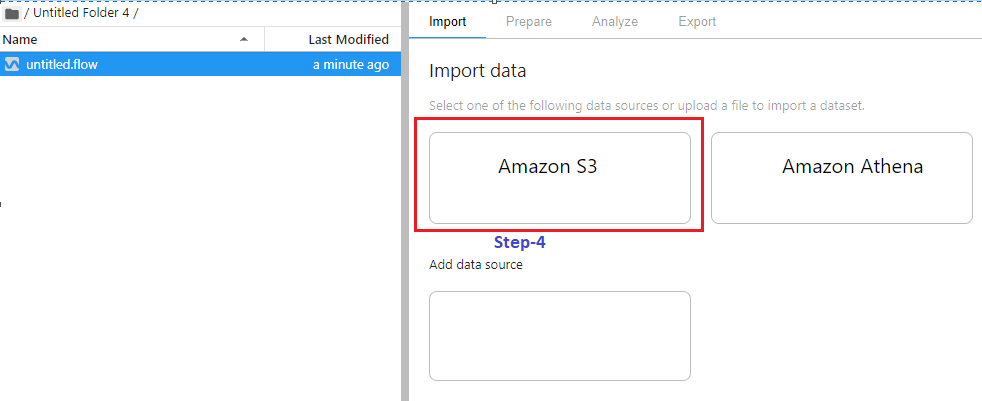

   #### 3. Please follow these steps to navigate to the desired S3 bucket/folder path to import the dataset from your source.   
   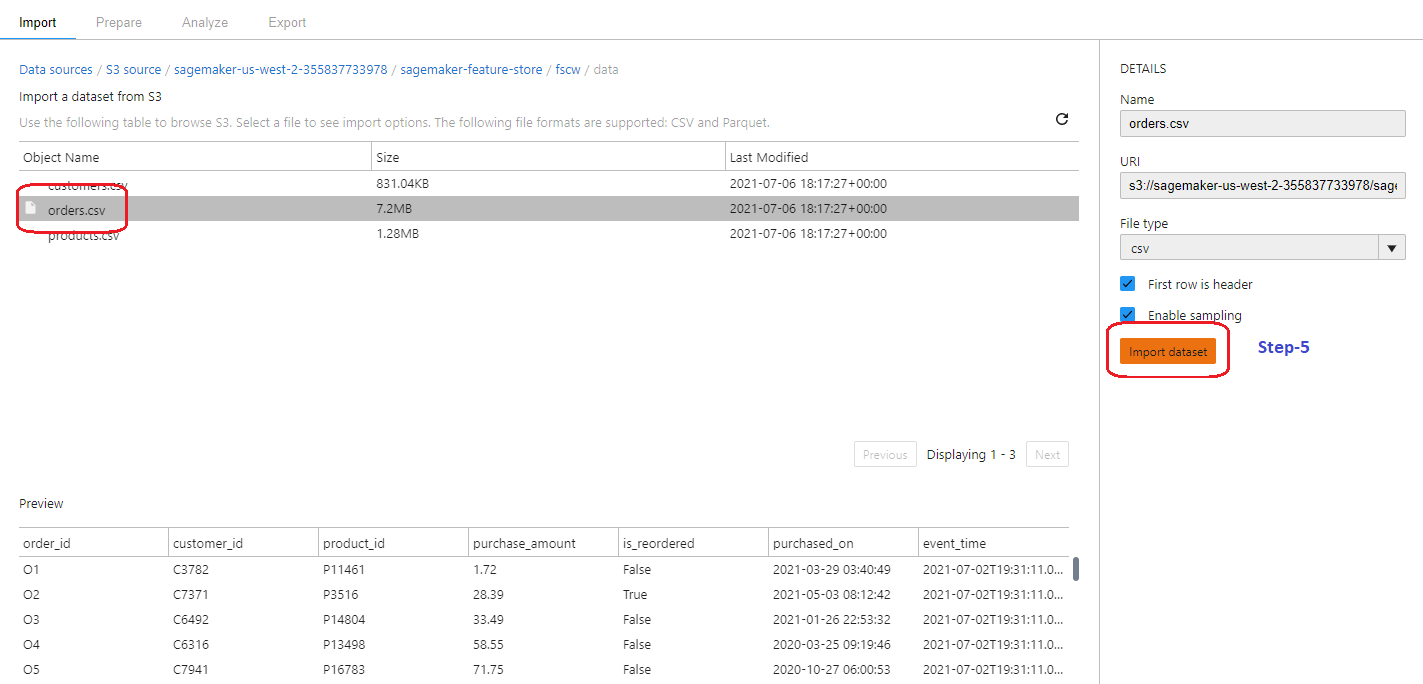
   

   #### 4. Please follow these steps to add a 'Transform' to your imported dataset.     
   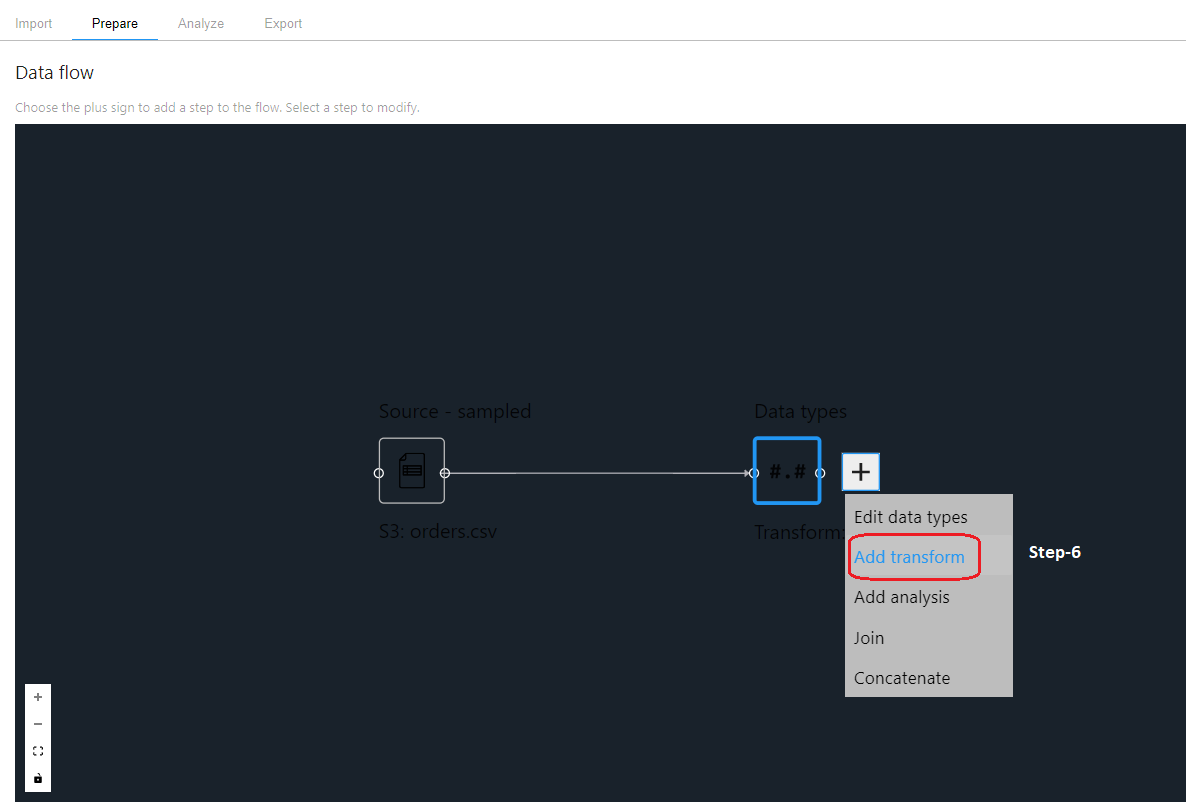
   

   #### 5. Please follow these steps to navigate to the desired transform to apply to a source column.   
   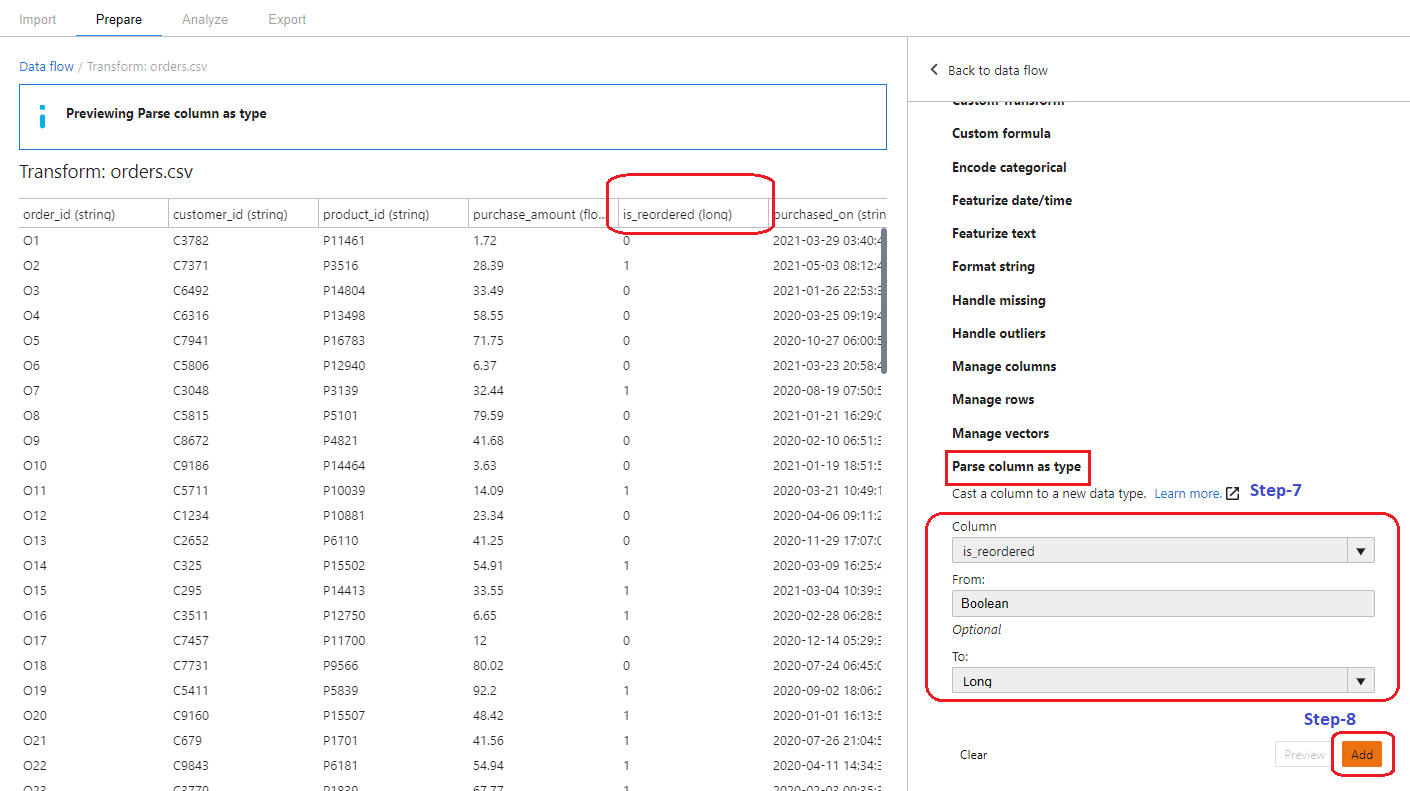
   

   #### 6. Please follow these steps to 'Export' the created workflow to create a notebook that would ingest the data in to a feature store..     
   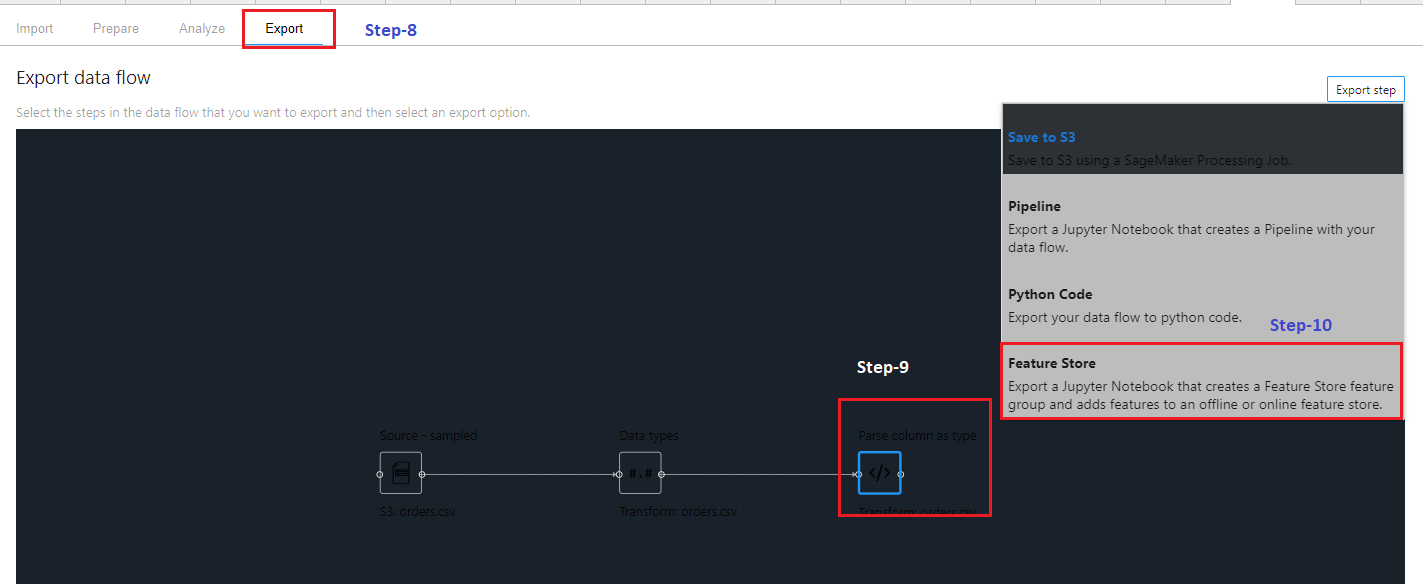
   

   #### A notebook is generated as shown below   

   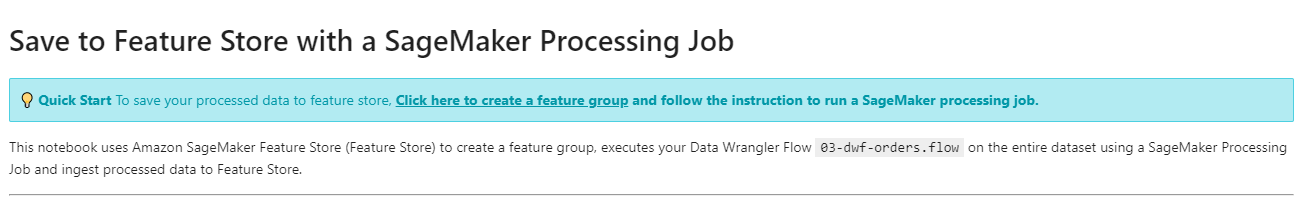

   #### 7. Please follow these steps to copy the value from the Output name variable (as shown below) that is auto-generated from the selected node's ID from the flowfile.   

   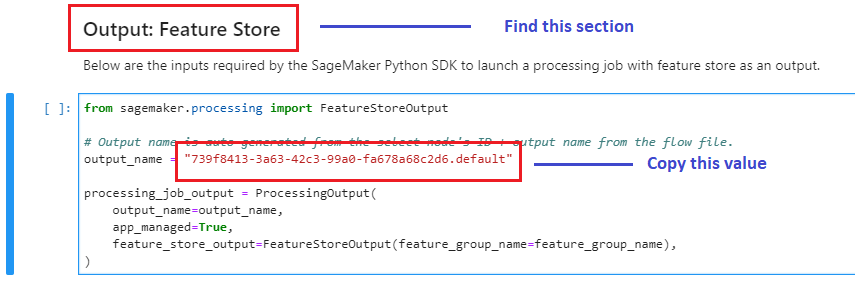

   #### 8. Please follow these steps to navigate to 'Save As' option to rename the Workflow file to 'orders.flow'     
   
   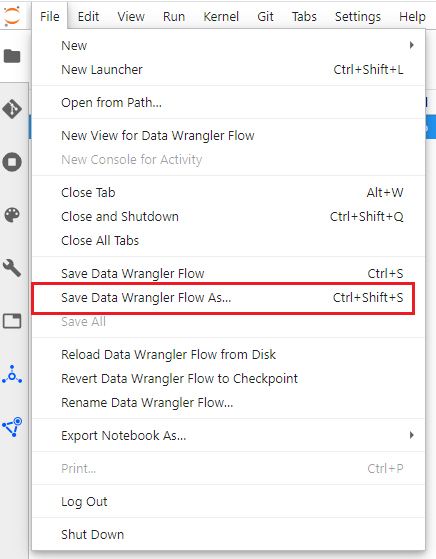
   

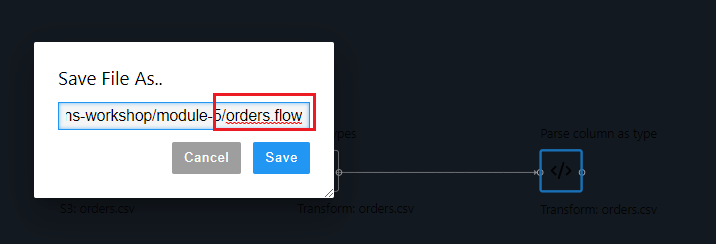

## ** END ** Creating a workflow using Data Wrangler (OPTIONAL)







# Inputs and Outputs

The below settings configure the inputs and outputs for the flow export.

<div class="alert alert-info"> 💡 <strong> Configurable Settings </strong>

In <b>Input - Source</b> you can configure the data sources that will be used as input by Data Wrangler

1. For S3 sources, configure the source attribute that points to the input S3 prefixes
2. For all other sources, configure attributes like query_string, database in the source's 
<b>DatasetDefinition</b> object.

If you modify the inputs the provided data must have the same schema and format as the data used in the Flow. 
You should also re-execute the cells in this section if you have modified the settings in any data sources.
</div>

In [ ]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.dataset_definition.inputs import AthenaDatasetDefinition, DatasetDefinition, RedshiftDatasetDefinition

data_sources = []

### Input: S3 Source: orders.csv

In [ ]:
ordersfilename='orders.csv'
# You can override this to point to other dataset on S3
print(f"Data source: {f'{bucketlocation}{ordersfilename}'}")

data_sources.append(ProcessingInput(
    source=f'{bucketlocation}{ordersfilename}', 
    destination=f'/opt/ml/processing/{ordersfilename}',
    input_name=ordersfilename,
    s3_data_type="S3Prefix",
    s3_input_mode="File",
    s3_data_distribution_type="FullyReplicated"
))


### Output: Feature Store 

##### Use the link below if you want to go back and create a Data Wrangler flow
[Create Data Wrangler Workflow](#Creating-a-workflow-using-Data-Wrangler-(OPTIONAL))

Below are the inputs required by the SageMaker Python SDK to launch a processing job with feature store as an output.

<div class="alert alert-warning" role="alert">
  <h4 class="alert-heading">Warning!!!</h4>
  <p>The output_name variable shown below should be configured only if you created you own flow file using Data Wrangler and have overwritten the original file.</p>
  <p>Use the value copied from Step-7 of the process used to create the DW flow.</p>
</div>

In [ ]:
# Output name is auto-generated from the select node's ID + output name from the flow file.
output_name = None #Use the Node ID from the provided DW flow file.
if output_name is None: 
    output_name = "739f8413-3a63-42c3-99a0-fa678a68c2d6.default"
logger.info(f'output_name = {output_name}')

In [ ]:
from sagemaker.processing import FeatureStoreOutput

processing_job_output = ProcessingOutput(
    output_name=output_name,
    app_managed=True,
    feature_store_output=FeatureStoreOutput(feature_group_name=feature_group_name),
)

## Upload Flow to S3

To use the Data Wrangler as an input to the processing job,  first upload your flow file to Amazon S3.

In [ ]:
import os
import json
import boto3

# name of the flow file which should exist in the current notebook working directory
flow_file_name = f'{flow_name}.flow'

# Load .flow file from current notebook working directory 
!echo "Loading flow file from current notebook working directory: $PWD"

#Read file from current notebook working directory
with open(flow_file_name) as f:
    flow = json.load(f)
#logger.info(f'Flow={flow}')

# Upload flow to S3
s3_client = boto3.client("s3")
orders_flow_file=f'{workshopfolder}data_wrangler_flows/{flow_export_name}.flow'
s3_client.upload_file(flow_file_name, bucket, orders_flow_file)
flow_s3_uri = f's3://{bucket}/{orders_flow_file}'
print(f"Data Wrangler flow {flow_file_name} uploaded to {flow_s3_uri}")

The Data Wrangler Flow is also provided to the Processing Job as an input source which we configure below.

In [ ]:
## Input - Flow: DWF-Orders.flow
flow_input = ProcessingInput(
    source=flow_s3_uri,
    destination="/opt/ml/processing/flow",
    input_name="flow",
    s3_data_type="S3Prefix",
    s3_input_mode="File",
    s3_data_distribution_type="FullyReplicated"
)

# Run Processing Job 
## Job Configurations

<div class="alert alert-info"> 💡 <strong> Configurable Settings </strong>

You can configure the following settings for Processing Jobs. If you change any configurations you will 
need to re-execute this and all cells below it by selecting the Run menu above and click 
<b>Run Selected Cells and All Below</b>

1. IAM role for executing the processing job. 
2. A unique name of the processing job. Give a unique name every time you re-execute processing jobs
3. Data Wrangler Container URL.
4. Instance count, instance type and storage volume size in GB.
5. Content type for each output. Data Wrangler supports CSV as default and Parquet.
6. Network Isolation settings
</div>

In [ ]:
import uuid

# IAM role for executing the processing job.
iam_role = sagemaker.get_execution_role()

# Unique processing job name. Give a unique name every time you re-execute processing jobs
flow_export_id = f"{strftime('%d-%H-%M-%S', gmtime())}-{str(uuid.uuid4())[:8]}"
processing_job_name = f"data-wrangler-flow-processing-{flow_export_id}"
print(f"Processing job name: {processing_job_name}")

# Data Wrangler Container URL.
container_id = get_container(region)
print(f"container_id: {container_id}")
container_uri = f'{container_id}.dkr.ecr.{region}.amazonaws.com/sagemaker-data-wrangler-container:1.x'
print(f"container_uri: {container_uri}")

# Processing Job Instance count and instance type.
instance_count = 2
instance_type = "ml.m5.4xlarge"

# Size in GB of the EBS volume to use for storing data during processing
volume_size_in_gb = 30

# Content type for each output. Data Wrangler supports CSV as default and Parquet.
output_content_type = "CSV"

# Network Isolation mode; default is off
enable_network_isolation = False

# Output configuration used as processing job container arguments 
output_config = {
    output_name: {
        "content_type": output_content_type
    }
}

## Create and Execute Processing Job

To launch a Processing Job, you will use the SageMaker Python SDK to create a Processor function.

In [ ]:
from sagemaker.processing import Processor
from sagemaker.network import NetworkConfig

processor = Processor(
    role=iam_role,
    image_uri=container_uri,
    instance_count=instance_count,
    instance_type=instance_type,
    volume_size_in_gb=volume_size_in_gb,
    network_config=NetworkConfig(enable_network_isolation=enable_network_isolation),
    sagemaker_session=sess
)

# Start Job
processor.run(
    inputs=[flow_input] + data_sources, 
    outputs=[processing_job_output],
    arguments=[f"--output-config '{json.dumps(output_config)}'"],
    wait=False,
    logs=False,
    job_name=processing_job_name
)

## Job Status

Below you wait for processing job to finish. If it finishes successfully, your feature group should be populated 
with transformed feature values. In addition the raw parameters used by the Processing Job will be printed.

In [ ]:
job_result = sess.wait_for_processing_job(processing_job_name)
logger.info(f'Job result={job_result}') 

You can check the status of your processing job as shown below. In case of errors, the log can be very helpful to debug.

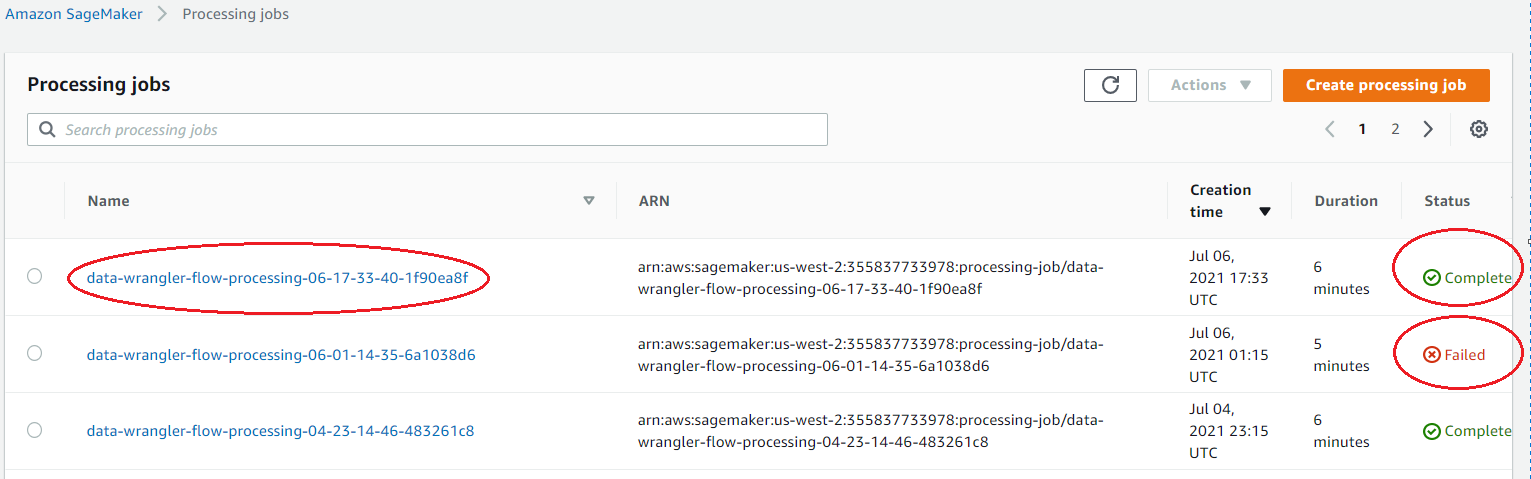

## Verify Processing Job Results

In [ ]:
import random

order_id =  f'O{random.randint(1, 5000)}'
logger.info(f"order_id={order_id}") 

featurestore_runtime_client = sess.boto_session.client('sagemaker-featurestore-runtime', region_name=region)
# Verify Processing Job Results by querying Feature Store
feature_record = featurestore_runtime_client.get_record(FeatureGroupName=feature_group_name, RecordIdentifierValueAsString=order_id)
logger.info(f"Feature Record={feature_record}") 

## Storing Variable Values

In [ ]:
# Storing the values of the Orders Feature Groupname and DW outputname
%store output_name
%store feature_group_name
# These variables will be used by Module-6

You can view newly created feature group in Studio, refer to [Use Amazon SageMaker Feature Store with Amazon SageMaker Studio](https://docs.aws.amazon.com/sagemaker/latest/dg/feature-store-use-with-studio.html)
for detailed guide. [Learn more about SageMaker Feature Store](https://github.com/aws/amazon-sagemaker-examples/tree/master/sagemaker-featurestore)